In [4]:
import pandas as pd
import pycountry_convert as pc

# Import libraries
import numpy as np
import os
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import shap
import xgboost as xgb

/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Define data folder
data_folder = "./DASS_data"
dataset = pd.read_csv("./DASS_data/data.csv", delimiter='\t', on_bad_lines='skip')

In [6]:
missing_values = dataset.isna().sum()
print(missing_values)

Q1A               0
Q1I               0
Q1E               0
Q2A               0
Q2I               0
              ...  
race              0
voted             0
married           0
familysize        0
major         11425
Length: 172, dtype: int64


In [7]:
# Drop multiple columns in-place
dataset.drop(["major"], axis=1, inplace=True)

In [8]:
# Define the questions contributing to each score
depression_questions = ['Q3A', 'Q5A', 'Q10A', 'Q13A', 'Q16A', 'Q17A', 'Q21A', 'Q24A', 'Q26A', 'Q31A', 'Q34A', 'Q37A', 'Q38A', 'Q42A']
anxiety_questions = ['Q2A', 'Q4A', 'Q7A', 'Q9A', 'Q15A', 'Q19A', 'Q20A', 'Q23A', 'Q25A', 'Q28A', 'Q30A', 'Q36A', 'Q40A', 'Q41A']
stress_questions = ['Q1A', 'Q6A', 'Q8A', 'Q11A', 'Q12A', 'Q14A', 'Q18A', 'Q22A', 'Q27A', 'Q29A', 'Q32A', 'Q33A', 'Q35A', 'Q39A']

# Identify columns that end with 'A'
columns_to_update = [col for col in dataset.columns if col.endswith('A')]
print(columns_to_update)

# Add 1 to each of these columns
for col in columns_to_update:
    dataset[col] = dataset[col] - 1

# Calculate the Depression, Anxiety, and Stress scores
dataset['Depression_Score'] = dataset[depression_questions].sum(axis=1)
dataset['Anxiety_Score'] = dataset[anxiety_questions].sum(axis=1)
dataset['Stress_Score'] = dataset[stress_questions].sum(axis=1)

['Q1A', 'Q2A', 'Q3A', 'Q4A', 'Q5A', 'Q6A', 'Q7A', 'Q8A', 'Q9A', 'Q10A', 'Q11A', 'Q12A', 'Q13A', 'Q14A', 'Q15A', 'Q16A', 'Q17A', 'Q18A', 'Q19A', 'Q20A', 'Q21A', 'Q22A', 'Q23A', 'Q24A', 'Q25A', 'Q26A', 'Q27A', 'Q28A', 'Q29A', 'Q30A', 'Q31A', 'Q32A', 'Q33A', 'Q34A', 'Q35A', 'Q36A', 'Q37A', 'Q38A', 'Q39A', 'Q40A', 'Q41A', 'Q42A']


In [9]:
# Define functions to categorize the scores
def categorize_depression(score):
    if score <= 9:
        return 0
    elif score <= 13:
        return 1
    elif score <= 20:
        return 2
    elif score <= 27:
        return 3
    else:
        return 4

def categorize_anxiety(score):
    if score <= 7:
        return 0
    elif score <= 9:
        return 1
    elif score <= 14:
        return 2
    elif score <= 19:
        return 3
    else:
        return 4

def categorize_stress(score):
    if score <= 14:
        return 0
    elif score <= 18:
        return 1
    elif score <= 25:
        return 2
    elif score <= 33:
        return 3
    else:
        return 4

In [10]:
# Apply the categorization functions
dataset['Depression_Level'] = dataset['Depression_Score'].apply(categorize_depression)
dataset['Anxiety_Level'] = dataset['Anxiety_Score'].apply(categorize_anxiety)
dataset['Stress_Level'] = dataset['Stress_Score'].apply(categorize_stress)

In [11]:
anxiety_data = dataset.drop(['Depression_Level', 'Stress_Level', 'Depression_Score', 'Stress_Score'], axis=1)

In [12]:
# Step 1: Identify columns ending with 'E'
time_columns = [col for col in anxiety_data.columns if col.endswith('E')]

# Step 3: Filter out rows with extreme values in any of the time columns
for col in time_columns:
    cutoff_value = 100000
    anxiety_data = anxiety_data[dataset[col] <= cutoff_value]

/var/folders/ck/2s74pj3s3_n1wnn8jc86lr3r0000gn/T/ipykernel_64809/530656904.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anxiety_data = anxiety_data[dataset[col] <= cutoff_value]
/var/folders/ck/2s74pj3s3_n1wnn8jc86lr3r0000gn/T/ipykernel_64809/530656904.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anxiety_data = anxiety_data[dataset[col] <= cutoff_value]
/var/folders/ck/2s74pj3s3_n1wnn8jc86lr3r0000gn/T/ipykernel_64809/530656904.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anxiety_data = anxiety_data[dataset[col] <= cutoff_value]
/var/folders/ck/2s74pj3s3_n1wnn8jc86lr3r0000gn/T/ipykernel_64809/530656904.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anxiety_data = anxiety_data[dataset[col] <= cutoff_value]
/var/folders/ck/2s74pj3s3_n1wnn8jc86lr3r0000gn/T/ipykernel_64809/530656904.py:7: UserWarning: Boolean Series key will be reindexed t

In [13]:
def encode_country(row):
    # Encode country into three major regions (east, west, other)
    country_code = row["country"]
    try:
        if country_code and country_code != "NONE":
            continent_name = pc.country_alpha2_to_continent_code(country_code)
            if continent_name == "AS":
                region_name = "east"
            elif continent_name in ["NA", "EU", "OC"]:
                region_name = "west"
            else:
                region_name = "other"
        else:
            region_name = ""
    except:
        region_name = ""
    return region_name
    
def encode_continent(row):
    # Encode country into three major regions (east, west, other)
    country_code = row["country"]
    try:
        if country_code and country_code != "NONE":
            continent_name = pc.country_alpha2_to_continent_code(country_code)
        else:
            continent_name = ""
    except:
        continent_name = ""
    return continent_name

def encode_age(row):
    # Encode age into groups
    age = int(row['age'])
    if age < 18:
        agegroup = 0
    elif age < 28:
        agegroup = 1
    elif age < 38:
        agegroup = 2
    elif age < 48:
        agegroup = 3
    elif age < 58:
        agegroup = 4
    elif age < 68:
        agegroup = 5
    else:
        agegroup = 6
    return agegroup

In [14]:
anxiety_data["agegroup"] = dataset.apply(lambda row: encode_age(row), axis=1)
anxiety_data["continent"] = dataset.apply(lambda row: encode_continent(row), axis=1)
anxiety_data["region"] = dataset.apply(lambda row: encode_country(row), axis=1)

In [15]:
# Filter data
anxiety_data.drop(anxiety_data[(anxiety_data['gender'] == 0) | (anxiety_data['gender'] == 3)].index, inplace=True)  # Male and females only
anxiety_data[anxiety_data['age'] >= 18]  # Adults only
anxiety_data = anxiety_data[anxiety_data['region'] != ""]  # Must have region
anxiety_data = anxiety_data.dropna()

# Remove data with countries that have strict data privacy laws (for public use only)
# Define the list of countries to exclude
countries_to_exclude = ["CH", "IN", "JA", "AU"]
# Filter the dataset to exclude the specified countries and continent
anxiety_data = anxiety_data[(anxiety_data['continent'] != "EU") & ~anxiety_data['country'].isin(countries_to_exclude)]

In [16]:
num_samples = anxiety_data.shape[0]
print("Number of samples:", num_samples)

Number of samples: 31629


In [17]:
# Data summary (after filtering)
print("\nAfter filtering:")
print(anxiety_data['gender'].value_counts())
print(anxiety_data['agegroup'].value_counts())
print(anxiety_data['age'].mean(), anxiety_data['age'].std())
print(anxiety_data['continent'].value_counts())
print(anxiety_data['region'].value_counts())
print(anxiety_data['Anxiety_Score'].value_counts())


After filtering:
gender
2    25094
1     6535
Name: count, dtype: int64
agegroup
1    20888
0     5434
2     3393
3     1043
4      592
5      216
6       63
Name: count, dtype: int64
23.420689873217615 23.621835097052116
continent
AS    22357
NA     8546
SA      306
AF      216
OC      204
Name: count, dtype: int64
region
east     22357
west      8750
other      522
Name: count, dtype: int64
Anxiety_Score
10    1166
13    1150
7     1134
6     1109
12    1106
8     1100
9     1097
14    1083
11    1078
16    1046
5     1018
4     1016
3      999
15     984
17     963
18     944
22     922
19     908
20     901
21     887
2      856
23     813
24     796
25     745
1      739
0      671
26     660
28     628
27     624
29     563
30     529
31     468
32     465
33     378
34     356
35     320
36     294
37     262
38     214
39     185
42     184
40     149
41     119
Name: count, dtype: int64


In [18]:
# Define the data based on your provided summary
table_data = {
    'Continent': ['Asia', 'Europe', 'North America', 'Other'],
    'Mean Age (years)': [23.6, 28.5, 29.9, 28.7],
    'Standard deviation Age (years)': [27.0, 11.3, 12.9, 11.6],
    'Males': [3896, 955, 2016, 350],
    'Females': [18246, 1543, 3990, 719]
}

# Create DataFrame
df = pd.DataFrame(table_data)

# Display the DataFrame
print(df)

# Convert the DataFrame to LaTeX format
latex_table = df.to_latex(index=False, caption="Demographic Information by Continent")

# Print the LaTeX table
print(latex_table)

       Continent  Mean Age (years)  Standard deviation Age (years)  Males  \
0           Asia              23.6                            27.0   3896   
1         Europe              28.5                            11.3    955   
2  North America              29.9                            12.9   2016   
3          Other              28.7                            11.6    350   

   Females  
0    18246  
1     1543  
2     3990  
3      719  
\begin{table}
\caption{Demographic Information by Continent}
\begin{tabular}{lrrrr}
\toprule
Continent & Mean Age (years) & Standard deviation Age (years) & Males & Females \\
\midrule
Asia & 23.600000 & 27.000000 & 3896 & 18246 \\
Europe & 28.500000 & 11.300000 & 955 & 1543 \\
North America & 29.900000 & 12.900000 & 2016 & 3990 \\
Other & 28.700000 & 11.600000 & 350 & 719 \\
\bottomrule
\end{tabular}
\end{table}



In [19]:
for col in anxiety_data.columns:
    if "TIPI" in col or "VCL" in col:
        anxiety_data = anxiety_data.drop([col], axis=1)
    elif col[0] == "Q" and (col[-1] == "E" or col[-1] == "I"):
        anxiety_data = anxiety_data.drop([col], axis=1)

In [20]:
# Define data folder
seed = 100
data_folder = "./DASS_data"

features_dataframe = anxiety_data.drop(['Anxiety_Level', 'Anxiety_Score'], axis=1)
features_dataframe.to_csv(os.path.join(data_folder, "original_features.csv"), index=None)

In [21]:
anxiety_score_counts = anxiety_data['Anxiety_Level'].value_counts()
anxiety_score_proportions = anxiety_score_counts / len(anxiety_data)
anxiety_score_counts, anxiety_score_proportions

(Anxiety_Level
 4    11462
 0     7542
 2     5583
 3     4845
 1     2197
 Name: count, dtype: int64,
 Anxiety_Level
 4    0.362389
 0    0.238452
 2    0.176515
 3    0.153182
 1    0.069462
 Name: count, dtype: float64)

In [22]:
def preprocess(dataframe):
    
    anxiety_level_0 = dataframe[dataframe['Anxiety_Level'] == 0]
    anxiety_level_1 = dataframe[dataframe['Anxiety_Level'] == 1]
    anxiety_level_2 = dataframe[dataframe['Anxiety_Level'] == 2]
    anxiety_level_3 = dataframe[dataframe['Anxiety_Level'] == 3]
    anxiety_level_4 = dataframe[dataframe['Anxiety_Level'] == 4]
    
    # Upsample the minority classes
    anxiety_level_0_upsampled = resample(anxiety_level_0, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    anxiety_level_1_upsampled = resample(anxiety_level_1, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    anxiety_level_2_upsampled = resample(anxiety_level_2, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    anxiety_level_3_upsampled = resample(anxiety_level_3, replace=True, n_samples=len(anxiety_level_4.index), random_state=seed)
    
    anxiety_data_upsampled = pd.concat([anxiety_level_0_upsampled, anxiety_level_1_upsampled, anxiety_level_2_upsampled, anxiety_level_3_upsampled, anxiety_level_4])
    anxiety_data = anxiety_data_upsampled.reset_index(drop=True)
    
    labels_dataframe = anxiety_data[['Anxiety_Level']].copy()
    features_dataframe = anxiety_data.drop(['Anxiety_Level', 'Anxiety_Score'], axis=1)
    features_dataframe.to_csv(os.path.join(data_folder, "original_features.csv"), index=None)
    
    # z-score normalization
    def z_score_norm(row, col, mean, stdev):
        z_score = (float(row[col]) - mean) / stdev
        return float(z_score)
    
    # One-hot encode gender and region
    label_encoder = LabelEncoder()
    onehot_encoder = OneHotEncoder()
    
    # Label encode the target
    label_encoder = LabelEncoder()
    dataframe['Anxiety_Level'] = label_encoder.fit_transform(dataframe['Anxiety_Level'])
    
    # Gender
    gender = label_encoder.fit_transform(features_dataframe["gender"])
    gender = pd.DataFrame(gender)
    gender = pd.DataFrame(onehot_encoder.fit_transform(gender).toarray())
    gender.columns = ["gender_m", "gender_f"]
    
    # Region
    region = label_encoder.fit_transform(features_dataframe["region"])
    region = pd.DataFrame(region)
    region = pd.DataFrame(onehot_encoder.fit_transform(region).toarray())
    region.columns = ["region_other", "region_east", "region_west"]
    
    # Combine and remove original columns
    features_dataframe = features_dataframe.drop(["gender", "country", "region", "agegroup", "continent"], axis=1)
    features_dataframe = pd.concat([features_dataframe, gender, region], axis=1)
    
    # One-hot encode question answers
    for col in features_dataframe.columns:
        if col[0] == "Q" and col[-1] == "A":
            temp = label_encoder.fit_transform(features_dataframe[col])
            temp = pd.DataFrame(temp)
            temp = pd.DataFrame(onehot_encoder.fit_transform(temp).toarray())

            col_names = []
            for c in temp.columns:
                col_names.append("{0}_{1}".format(col, c))
            temp.columns = col_names

            features_dataframe = features_dataframe.drop([col], axis=1)
            features_dataframe = pd.concat([features_dataframe, temp], axis=1)
    
    # Normalize numerical columns (Use z-score)
    mean = features_dataframe["age"].mean()
    stdev = features_dataframe["age"].std()
    features_dataframe["age_norm"] = features_dataframe.apply(
                    lambda row: z_score_norm(row, "age", mean, stdev), axis=1)
    features_dataframe = features_dataframe.drop(["age"], axis=1)
    

    return features_dataframe, labels_dataframe

In [23]:
# Split into features and labels, save as CSV
features_df, labels_df = preprocess(anxiety_data)
# One hot coded. Save as CSV
features_df.to_csv(os.path.join(data_folder, "features.csv"), index=None)
labels_df.to_csv(os.path.join(data_folder, "labels.csv"), index=None)

In [24]:
anxiety_score_counts = labels_df['Anxiety_Level'].value_counts()
anxiety_score_proportions = anxiety_score_counts / len(labels_df)
anxiety_score_counts, anxiety_score_proportions

(Anxiety_Level
 0    11462
 1    11462
 2    11462
 3    11462
 4    11462
 Name: count, dtype: int64,
 Anxiety_Level
 0    0.2
 1    0.2
 2    0.2
 3    0.2
 4    0.2
 Name: count, dtype: float64)

In [18]:
from mrmr import mrmr_classif


train_feats = pd.read_csv(os.path.join(data_folder, "features.csv"))
train_feats = train_feats.drop(["age_norm", "gender_m", "gender_f", "region_other", "region_east", "region_west"], axis=1)  # Comment this line to include demographics
labels = pd.read_csv(os.path.join(data_folder, "labels.csv"))

labels = labels["Anxiety_Level"]

selected_features = mrmr_classif(X=train_feats, y=labels, K=10)
print(selected_features)

100%|██████████| 10/10 [00:01<00:00,  5.14it/s]

['Q28A_0', 'Q30A_1', 'Q7A_0', 'Q36A_0', 'Q40A_3', 'Q4A_0', 'Q20A_3', 'Q20A_0', 'Q41A_0', 'Q9A_3']


In [19]:
# Not one-hot encoded dataset
train_feats = anxiety_data # Using sample dataset. Change the file name accordingly if using another dataset.
train_feats = train_feats.drop(["country","gender","age","agegroup","continent","region","Anxiety_Score", "Anxiety_Level"], axis=1)

labels = anxiety_data["Anxiety_Level"]

# print(MRMR(train_feats.to_numpy(), labels.to_numpy().ravel(), show_top)) # The customized function approach
selected_features = mrmr_classif(X=train_feats, y=labels, K=10) # The mrmr library approach
print(selected_features)

100%|██████████| 10/10 [00:01<00:00,  6.65it/s]

['Q28A', 'Q20A', 'Q40A', 'Q7A', 'Q36A', 'Q9A', 'Q4A', 'Q41A', 'Q30A', 'Q25A']


In [37]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Load the dataset
X = pd.read_csv(os.path.join(data_folder, "original_features.csv"))
y = pd.read_csv(os.path.join(data_folder, "labels.csv"))
for column in X.columns:
    if "A" not in column:
        X.drop([column], axis=1, inplace=True)

print(X.shape, y.shape)


(57310, 42) (57310, 1)


In [38]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(45848, 42) (11462, 42) (45848, 1) (11462, 1)


In [39]:
model = RandomForestClassifier(n_estimators=100,random_state=1200)
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=1200)

In [40]:
# Create a SHAP explainer object
explainer = shap.TreeExplainer(model)



(45848, 42, 5)


In [ ]:
# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)
print(shap_values.shape)

In [51]:
# Aggregate SHAP values across classes and samples
shap_values_abs = np.abs(shap_values).sum(axis=2).mean(axis=0)
print(shap_values_abs.shape)
# Ensure the resulting array is 1-dimensional
shap_values_abs = shap_values_abs.flatten()
print(shap_values_abs.shape)

AxisError: axis 2 is out of bounds for array of dimension 2

In [52]:
# Create a DataFrame with feature names and their mean absolute SHAP values
shap_summary = pd.DataFrame({'feature': X_train.columns, 'shap_value': shap_values_abs})

# Sort the features by SHAP value in descending order
shap_summary = shap_summary.sort_values(by='shap_value', ascending=False)
print(shap_summary)

ValueError: All arrays must be of the same length

In [27]:
# Calculate SHAP values for a single prediction (first instance of the test set)
# shap_values_single = explainer.shap_values(X_test.iloc[0, :].values.reshape(1, -1))

# # For multi-class models, shap_values_single will be a list of arrays
# # Here, we choose the SHAP values for the specific class (e.g., class 0)
# shap_values_single_class = shap_values_single[0][0]

# # Create a waterfall plot for the first instance and specific class
# shap.waterfall_plot(shap.Explanation(values=shap_values_single_class, 
#                                      base_values=explainer.expected_value[0], 
#                                      data=X_test.iloc[0, :], 
#                                      feature_names=X_test.columns.tolist()))

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import classification_report

In [25]:
# Load the data
features = pd.read_csv('DASS_data/original_features.csv')  # Update with the correct file path
labels = pd.read_csv('DASS_data/labels.csv')      # Update with the correct file path

In [28]:
# Specify the desired features
selected_features = ['Q40A', 'Q28A', 'Q20A', 'Q36A', 'Q9A', 'Q2A', 'Q25A', 'Q30A', 'Q7A', 'Q4A']

# Extract the selected features
X = features[selected_features]
y = labels['Anxiety_Level']  # Ensure 'label' column contains the multi-class labels (0-4)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [410]:
# Define the neural network
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')  # 5 output units for the 5 classes
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=32, validation_split=0.2)

Epoch 1/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 700us/step - accuracy: 0.4669 - loss: 1.1882 - val_accuracy: 0.7388 - val_loss: 0.5831
Epoch 2/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.6985 - loss: 0.6763 - val_accuracy: 0.7724 - val_loss: 0.5236
Epoch 3/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 632us/step - accuracy: 0.7243 - loss: 0.6342 - val_accuracy: 0.7802 - val_loss: 0.5065
Epoch 4/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - accuracy: 0.7364 - loss: 0.6047 - val_accuracy: 0.7841 - val_loss: 0.4993
Epoch 5/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 631us/step - accuracy: 0.7437 - loss: 0.5861 - val_accuracy: 0.7906 - val_loss: 0.4868
Epoch 6/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - accuracy: 0.7535 - loss: 0.5690 - val_accuracy: 0.7950 - val_loss: 0.4770
Epoch 7/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - accuracy: 0.7522 - loss: 0.5663 - val_accuracy: 0.7955 - val_loss: 0.4793
Epoch 8/1000
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - ac

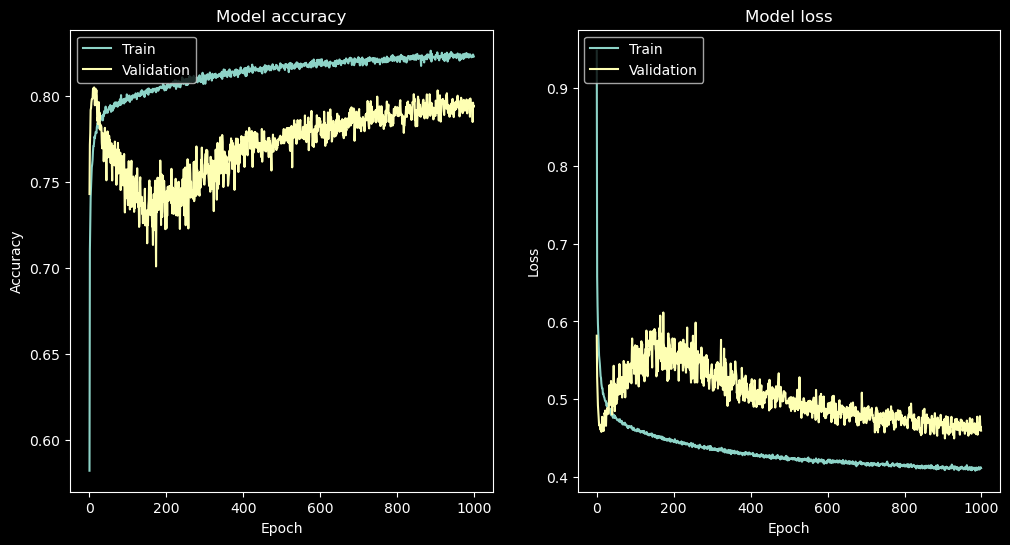

In [79]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [137]:
import torch
# Splitting data to train val test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5)
# Converting data to Torch tensor
train_input = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
train_label = torch.tensor(y_train.to_numpy(), dtype=torch.long)
val_input = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
val_label = torch.tensor(y_val.to_numpy(), dtype=torch.long)
test_input = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
test_label = torch.tensor(y_test.to_numpy(), dtype=torch.long)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [108]:
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'val_input': val_input,
    'val_label': val_label,
    'test_input': test_input,
    'test_label': test_label
}

In [2]:
from kan import KAN

kan_model = KAN([10, 7, 5], grid=10, k=3)

In [66]:
# Fuctions for getting accuracy scores while training
def train_acc():
    preds = torch.argmax(kan_model(dataset['train_input']), dim=1)
    return torch.mean((preds == dataset['train_label']).float())

def test_acc():
    preds = torch.argmax(kan_model(dataset['test_input']), dim=1)
    return torch.mean((preds == dataset['test_label']).float())

In [3]:
# KAN model training
results = kan_model.train({'train_input': train_input, 'train_label': train_label, 'test_input': val_input, 'test_label': val_label},
                      metrics=(train_acc, test_acc),
                      opt="LBFGS", steps=100, loss_fn=torch.nn.CrossEntropyLoss())

NameError: name 'train_input' is not defined

In [ ]:
# Predictions of train val and test datasets
test_preds = torch.argmax(kan_model.forward(test_input).detach(),dim=1)
test_labels = test_label

train_preds = torch.argmax(kan_model.forward(train_input).detach(),dim=1)
train_labels = train_label

val_preds = torch.argmax(kan_model.forward(val_input).detach(),dim=1)
val_labels = val_label


# Evaluate metrics

print("Train ACC:", accuracy_score(train_labels.numpy(), train_preds.numpy()))

print("Val ACC:", accuracy_score(val_labels.numpy(), val_preds.numpy()))

print("Test ACC:", accuracy_score(test_labels.numpy(), test_preds.numpy()))

Train ACC: 0.7963207617718174
Val ACC: 0.7978129362494183
Test ACC: 0.7948121437710829


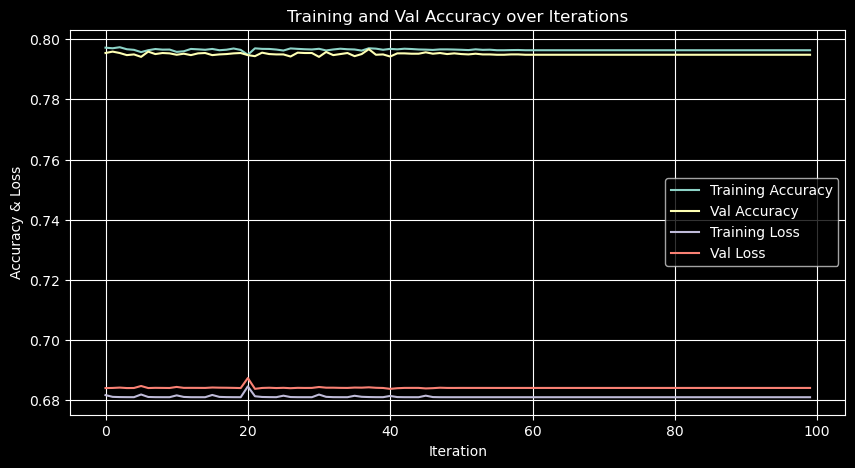

In [80]:
import matplotlib.pyplot as plt
# Learning curve based on ACC and LOSS
plt.figure(figsize=(10, 5))
plt.plot(results["train_acc"], label='Training Accuracy')
plt.plot(results["test_acc"], label='Val Accuracy')
plt.plot(results["train_loss"], label='Training Loss')
plt.plot(results["test_loss"], label='Val Loss')
plt.title('Training and Val Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy & Loss')
plt.legend()
plt.grid(True)
plt.show()

In [152]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)

In [153]:
clf.fit(X_train, y_train)

KNeighborsClassifier()

In [154]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
y_pred = clf.predict(X_test)
print("Accuracy of KNN Regression:",accuracy_score(y_test, y_pred))


Accuracy of KNN Regression: 0.829523643343221


In [158]:
#Libraries to Build Ensemble Model : Random Forest Classifier 
# Create the parameter grid based on the results of random search 
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [159]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
# Performing CV to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}])

In [160]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(y_train)
y_test = encoder.transform(y_train)

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(X_test)
Y_pred_label = list(encoder.inverse_transform(Y_pred))

Best score for training data: 0.8009292227746212 

Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 



In [ ]:
from sklearn.svm import SVC

# Create the SVM model with the best parameters
svm_model = SVC(C=100, kernel='rbf', gamma=0.001)

# Fit the model to the training data
svm_model.fit(X_train, y_train)

In [29]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, cohen_kappa_score, roc_curve
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import os
import random
import pickle
import matplotlib.pyplot as plt

# Define confidence interval function
def confidence_interval(data):
    return np.percentile(data, 97.5), np.percentile(data, 2.5)

# Define the Keras MLP model function
def create_mlp(input_dim):
    model = Sequential([
        Dense(128, input_dim=input_dim, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dense(5, activation='softmax')  # 5 output units for the 5 classes
    ])
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

import torch
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class KANWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dims, grid, k, steps=100):
        self.input_dims = input_dims
        self.grid = grid
        self.k = k
        self.steps = steps
        self.kan_model = KAN(input_dims, grid=grid, k=k)
        
    def fit(self, X, y):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if isinstance(y, pd.Series):
            y = y.to_numpy()
        
        train_input = torch.tensor(X, dtype=torch.float32)
        train_label = torch.tensor(y, dtype=torch.long)
        val_input = train_input  # Assuming using same data for simplicity, modify as needed
        val_label = train_label  # Assuming using same data for simplicity, modify as needed
        
        # Functions for getting accuracy scores while training
        def train_acc():
            preds = torch.argmax(self.kan_model(train_input), dim=1)
            return torch.mean((preds == train_label).float())

        def test_acc():
            preds = torch.argmax(self.kan_model(val_input), dim=1)
            return torch.mean((preds == val_label).float())

        # KAN model training
        self.kan_model.train({'train_input': train_input, 'train_label': train_label, 
                              'test_input': val_input, 'test_label': val_label},
                             metrics=(train_acc, test_acc),
                             opt="LBFGS", steps=self.steps, loss_fn=torch.nn.CrossEntropyLoss())
        
        return self
    
    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        test_input = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            preds = torch.argmax(self.kan_model(test_input), dim=1)
        return preds.numpy()
    
    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        test_input = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            output = self.kan_model(test_input)
        return torch.nn.functional.softmax(output, dim=1).numpy()
    
    def score(self, X, y):
        preds = self.predict(X)
        return accuracy_score(y, preds)



question_numbers = [1, 2, 3, 4, 5, 6, 7, 8]         # Numbers of questions from DASS to run through
target = "Anxiety_Level"
models_to_train = 10        # Number of models for each number of questions from DASS
models_per_question = 50    # Number of ensembles per model
test_split = 0.1
model_type = "lr"     # Specify model type (xgb, rf, lr, svm, mlp)
seed = 42
random.seed(seed)
questions = [40, 28, 20, 36, 9, 2, 25, 30, 7, 4]


ACCS = []
AUCS = []
PRES = []
RECS = []
F1S = []
AUC_STDEV = []
F1_STDEV = []
AUC_95CI_U = []
AUC_95CI_D = []
F1_95CI_U = []
F1_95CI_D = []

features_df = pd.read_csv(os.path.join(data_folder, "features.csv"))
labels_df = pd.read_csv(os.path.join(data_folder, "labels.csv"))
questions = [40, 28, 20, 36, 9, 2, 25, 30, 7, 4]

Training model 0


Inner Loop Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training iteration 0


/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Inner Loop Progress:  10%|█         | 1/10 [01:17<11:41, 77.98s/it]/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`

Training model 1


Inner Loop Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training iteration 0


Inner Loop Progress:  10%|█         | 1/10 [01:19<11:57, 79.67s/it]/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Inner Loop Progress:  20%|██        | 2/10 [02:38<10:34, 79.29s/it]/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed 

Training model 2


Inner Loop Progress:   0%|          | 0/10 [00:00<?, ?it/s]/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training iteration 0


Inner Loop Progress:  10%|█         | 1/10 [01:15<11:22, 75.87s/it]/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-07-19 15:32:59.755885: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: Expected begin, end, and strides to be 1D equal size tensors, but got shapes [0], [1], and [1] in

InvalidArgumentError: Graph execution error:

Detected at node strided_slice defined at (most recent call last):
  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/runpy.py", line 86, in _run_code

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/var/folders/ck/2s74pj3s3_n1wnn8jc86lr3r0000gn/T/ipykernel_64809/3999284932.py", line 106, in <module>

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py", line 1501, in fit

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py", line 770, in fit

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py", line 938, in _fit

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/scikeras/wrappers.py", line 535, in _fit_keras_model

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 104, in one_step_on_data

  File "/Users/rogersyang/Documents/SUDSCodeBase/long_to_short_dass/long-to-short/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

Expected begin, end, and strides to be 1D equal size tensors, but got shapes [0], [1], and [1] instead.
	 [[{{node strided_slice}}]] [Op:__inference_one_step_on_iterator_219671911]

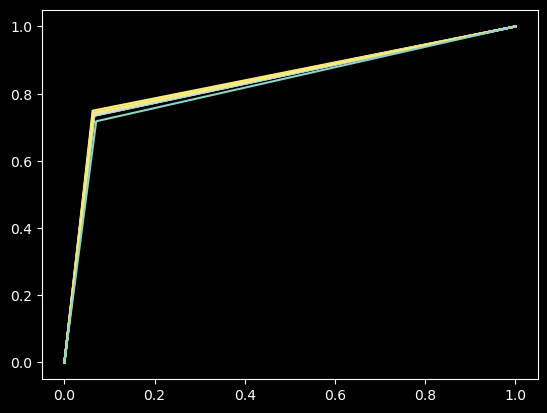

In [53]:
# For different numbers of questions from DASS-42
for num_questions in range(8, 11):
    models_info = {}

    accs = []
    aucs = []
    pres = []
    recs = []
    f1s = []
    auc_stdev = []
    f1_stdev = []
    auc_95ci_u = []
    auc_95ci_d = []
    f1_95ci_u = []
    f1_95ci_d = []
    lst_comb = []

    model_num = 0
    for a in range(10):  # Adjust the number of models to train as needed
        model = {}

        print("Training model", a)
        cols = ["gender_m", "gender_f", "region_other", 
                "region_east", "region_west", "age_norm"]

        if num_questions == 1:
            if a >= len(questions):
                break
            question_nums = [questions[a]]
        else:
            question_nums = random.sample(questions, num_questions)
            question_nums.sort()
            while question_nums in lst_comb:
                question_nums = random.sample(questions, num_questions)
            lst_comb.append(question_nums)

        for q in question_nums:
            for j in range(4):
                col_name = f"Q{q}A_{j}"  # Adjust column name formatting as necessary
                if col_name in features_df.columns:
                    cols.append(col_name)
                else:
                    print(f"Warning: Column {col_name} not found in features_df. Skipping this column.")

        features = features_df[cols]

        labels = labels_df.copy()

        np.random.seed(seed)
        shufId = np.random.permutation(len(labels))
        index = int(test_split * len(labels))

        df_prist = features.iloc[shufId[0:index]]
        df_trainvalid = features.iloc[shufId[index:]]

        gt_prist = labels.iloc[shufId[0:index]]
        gt_trainvalid = labels.iloc[shufId[index:]]

        df_prist.to_csv(os.path.join(data_folder, "prist_features.csv"), index=False)
        gt_prist.to_csv(os.path.join(data_folder, "prist_labels.csv"), index=False)

        accs1 = []
        aucs1 = []
        pres1 = []
        recs1 = []
        f1s1 = []
        ensemble_models = []

        for b in tqdm(range(10), desc="Inner Loop Progress", leave=False):  # Adjust the number of iterations as needed
            if b % 10 == 0:
                print("Training iteration", b)

            np.random.seed(b)
            shufId = np.random.permutation(len(gt_trainvalid))
            index = int((1/9) * len(gt_trainvalid))

            df_valid = df_trainvalid.iloc[shufId[0:index]]
            df_train = df_trainvalid.iloc[shufId[index:]]

            gt_valid = gt_trainvalid.iloc[shufId[0:index]]
            gt_train = gt_trainvalid.iloc[shufId[index:]]

            df_valid = df_valid.reset_index(drop=True)
            df_train = df_train.reset_index(drop=True)

            gt_valid = gt_valid.reset_index(drop=True)
            gt_train = gt_train.reset_index(drop=True)

            # Define the individual models
            mlp = KerasClassifier(build_fn=create_mlp, input_dim=df_train.shape[1], epochs=100, batch_size=32, validation_split=0.2, verbose=0)
            # knn = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
            # svm = SVC(C=100, kernel='rbf', gamma=0.001, probability=True)
            # kan = KANWrapper(input_dims=[10, 7, 5], grid=10, k=3)

            # Define the stacking classifier
            # estimators = [
            #     ('mlp', mlp),
            #     ('knn', knn),
            #     ('svm', svm),
            #     ('kan', kan)
            # ]

            # clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

            # clf.fit(df_train, gt_train.values.ravel())
            mlp.fit(df_train, gt_train.values.ravel())

            xgbpprist = mlp.predict(df_prist)
            xgbpprist = pd.DataFrame(xgbpprist)

            # Evaluation
            target_names = ['class1', 'class2', 'class3', 'class4', 'class5']  # Adjust class names as needed
            cr = classification_report(gt_prist, xgbpprist, target_names=target_names, output_dict=True)
            precision = cr["weighted avg"]["precision"]
            recall = cr["weighted avg"]["recall"]
            f1score = cr["weighted avg"]["f1-score"]

            acc_score = accuracy_score(gt_prist, xgbpprist)
            auc_score = roc_auc_score(label_binarize(gt_prist, classes=[0, 1, 2, 3, 4]), label_binarize(xgbpprist, classes=[0, 1, 2, 3, 4]), multi_class='ovr')
            fpr, tpr, thresh = roc_curve(label_binarize(gt_prist, classes=[0, 1, 2, 3, 4]).ravel(), label_binarize(xgbpprist, classes=[0, 1, 2, 3, 4]).ravel())
            plt.plot(fpr, tpr)           

            accs1.append(acc_score)
            aucs1.append(auc_score)
            pres1.append(precision)
            recs1.append(recall)
            f1s1.append(f1score)
            ensemble_models.append(mlp)

        mean_acc1 = np.mean(accs1)
        mean_auc1 = np.mean(aucs1)
        stdev_auc1 = np.std(aucs1)
        ci_auc1_u, ci_auc1_d = confidence_interval(aucs1)
        mean_pre1 = np.mean(pres1)
        mean_rec1 = np.mean(recs1)
        mean_f11 = np.mean(f1s1)
        stdev_f11 = np.std(f1s1)
        ci_f11_u, ci_f11_d = confidence_interval(f1s1)

        accs.append(mean_acc1)
        aucs.append(mean_auc1)
        auc_stdev.append(stdev_auc1)
        auc_95ci_u.append(ci_auc1_u)
        auc_95ci_d.append(ci_auc1_d)
        pres.append(mean_pre1)
        recs.append(mean_rec1)
        f1s.append(mean_f11)
        f1_stdev.append(stdev_f11)
        f1_95ci_u.append(ci_f11_u)
        f1_95ci_d.append(ci_f11_d)

        model["questions"] = question_nums
        model["knn_params"] = mlp.get_params()
        model["acc_score"] = acc_score
        model["auc_score"] = mean_auc1
        model["f1_score"] = mean_f11

        models_info[model_num] = model
        model_num += 1

    mean_acc = np.mean(accs)
    mean_auc = np.mean(aucs)
    stdev_auc = np.mean(auc_stdev)
    ci_auc_u = np.mean(auc_95ci_u)
    ci_auc_d = np.mean(auc_95ci_d)
    mean_pre = np.mean(pres)
    mean_rec = np.mean(recs)
    mean_f1  = np.mean(f1s)
    stdev_f1 = np.mean(f1_stdev)
    ci_f1_u = np.mean(f1_95ci_u)
    ci_f1_d = np.mean(f1_95ci_d)

    percentile_list = pd.DataFrame(
    {
        'accuracy': accs,
        'auc_roc': aucs,
        'auc_stdev': auc_stdev,
        'auc_95ci_u': auc_95ci_u,
        'auc_95ci_d': auc_95ci_d,
        'precision': pres,
        'recall': recs,
        'f1_score': f1s,
        'f1_stdev': f1_stdev,
        'f1_95ci_u': f1_95ci_u,
        'f1_95ci_d': f1_95ci_d,
    })
    percentile_list.to_csv('./data/results_{}.csv'.format(model_type), mode='a', header=True)

    print("\nNumber of questions:", num_questions)
    print("Mean AUC      :", mean_auc)
    print("Stdev AUC     :", stdev_auc)
    print("95th CI AUC   :", ci_auc_u, ci_auc_d)
    print("Mean F1-Score :", mean_f1)
    print("Stdev F1      :", stdev_f1)
    print("95th CI F1    :", ci_f1_u, ci_f1_d)

    ACCS.append(mean_acc)
    AUCS.append(mean_auc)
    AUC_STDEV.append(stdev_auc)
    AUC_95CI_U.append(ci_auc_u)
    AUC_95CI_D.append(ci_auc_d)
    PRES.append(mean_pre)
    RECS.append(mean_rec)
    F1S.append(mean_f1)
    F1_STDEV.append(stdev_f1)
    F1_95CI_U.append(ci_f1_u)
    F1_95CI_D.append(ci_f1_d)

    with open("./data/models_{}.bin".format(model_type), "wb") as f:
        # pickle.dump(models, f)
        pickle.dump(models_info, f)